#Code

##Load and transform data

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

def encode_dataset(dataset,
                   input_columns = [1,6],
                   target_columns = [0,1], 
                   categorial_input = True):
    """Function that given a dataframe with input and output columns
    return a dataset list where each element is in shape of <input, output>
    with optional one-hot encoding of the input"""
    start_input_column = min(input_columns)
    total_columns = max(input_columns)
    start_output_column = min(target_columns)
    total_output_columns = max(target_columns)
    ds = [] #initialize the dataset, its element will be in shape of <input, output>
    if categorial_input:
        dd = {} #initialize a dictionary cointaning for every column (input component) 
                #the number of distinct elements for one-hot encoding of each column
        i = 0
        for column in range(total_columns):
            m = max(set(dataset.iloc[:, start_input_column+column]))
            dd[i] = m #assign the number of distinct elements for each column
            i += 1
        input_range = np.sum([v for v in dd.values()]) #length of the future one-hot vector for all the columns
        
    for line in range(len(dataset)):
        if categorial_input:
            input_ = np.zeros(input_range) #initialize a 0 vector
            l = list(dataset.iloc[line, start_input_column:total_columns+start_input_column]) #select the input columns from the dataframe
            i = 0
            index = 0 #index of the one-hot slots encoding each column
            for value in l:
                input_[index+value-1] = 1 #assign 1 to the binary slot corrisponding to the current value of the column
                index += dd[i] #update the index variable to the next column
                i += 1 #update the index of the column for future access on the dd dictionary to select the number of slots for each column
        else:
            input_= np.array(dataset.iloc[line, start_input_column:total_columns + start_input_column], dtype='object') #select the input columns from the dataframe
        target = np.array(dataset.iloc[line, start_output_column:start_output_column + total_output_columns], dtype='object') #select the output columns from the dataframe
        example=input_,target
        ds.append(example)
    return ds

def load_dataset (i=1):
  """Loads training and test set of Monk_i if i is given, 
  otherwise loads ML-CUP22 dataset"""
  if i in [1, 2, 3] :
      train = pd.read_csv(r"/content/drive/Shareddrives/ML-22/monks"+str(i)+"_training.csv")
      training_set = encode_dataset(train)

      test = pd.read_csv(r"/content/drive/Shareddrives/ML-22/monks"+str(i)+"_test.csv")
      test_set = encode_dataset(test)
  else:
      df = pd.read_csv(r"/content/drive/Shareddrives/ML-22/ML-CUP22-TR.csv", comment='#', skiprows=7, header=None)
      df = df.drop(columns = 0)
      # returns the training set and an internal test set
      # with respectively 70% and 30% splitting
      train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
      scaler = MinMaxScaler()
      #apply data normalization for the train set
      X_train = scaler.fit_transform(train_df.iloc[:,0:9].values)
      #apply data normalization for the internal test set
      X_test = scaler.fit_transform(test_df.iloc[:,0:9].values)
      training_set = []
      test_set = []
      #encode the training set in shape of a list of <input, output> elements
      for i in range(len(X_train)):
          training_set += [[np.array(X_train[:, 0:9][i]),np.array((train_df.iloc[:,-2:].values)[i])]]
      #encode the internal test set in shape of a list of <input, output> elements
      for i in range(len(X_test)):
          test_set += [[np.array(X_test[:, 0:9][i]),np.array((test_df.iloc[:,-2:].values)[i])]]

  return training_set, test_set

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Activation functions

In [ ]:
import numpy as np

def sigmoid(x, a=1):
    x = np.array([float(b) for b in x]) #float conversion of the vector x to avoid having a 0 integer in the np.exp argument
    return 1 / (1 + np.exp(-(a * x)))


def sigmoid_derivative(x, a=1):
    return a * sigmoid(x, a=a) * (1 - sigmoid(x, a=a))


def relu(x, a=None):
    return np.maximum(0, x)


def relu_derivative(x, a=None):
    return (np.sign(x)+1)/2


def act_f(label, k):
    """return the activation functions with k=0,
    their derivative with k=1 """
    if label == "sigmoid" and k == 0:
        return sigmoid

    if label == "sigmoid" and k == 1:
        return sigmoid_derivative

    if label == "relu" and k == 0:
        return relu

    if label == "relu" and k == 1:
        return relu_derivative

##MLP class

In [ ]:
import numpy as np
import math
import random
from numpy.random import default_rng
rng = default_rng()

   
class MLP:

    def __init__(self, sizes, activation, weights_std=1/3, task = 'regression',
                 xavier = True, a=1):
        """ sizes is a list of dimensions (number of units for each layer)
            activation is a string (sigmoid/relu) related to activation function
            used in the hidden units, #n of hidden units can be an hyperparameter"""
        self.sizes = sizes
        self.weights_std = weights_std
        self.activation = activation
        self.a = a
        self.task = task
        self.xavier = xavier
        self.n_input = sizes[0]  # number of input units
        self.n_output = sizes[-1]  # number of output units
        if xavier:
          self.hidden_layers = np.array([rng.uniform(-(6/(y+x))**(0.5),
                                                     (6/(y+x))**(0.5),
                                                     (y,x)).tolist()
                                         for (y,x) in 
                                         zip(self.sizes[1:], self.sizes[:-1])],
                                         dtype = object)
        else:
          self.hidden_layers = np.array([(rng.normal(0,weights_std,(y,x))).tolist()
                                      for (y, x) in
                                      zip(self.sizes[1:], self.sizes[:-1])], 
                                      dtype=object)
        # list of weight matrices for hidden layers
        self.biases = np.array([np.zeros(x)
                                for x in self.sizes[1:]], 
                                dtype=object)
        # list of biases vector

    def reset_weights(self):
        """Method that resets the weights according to 
        the initialization strategy of the MLP object"""
        #resets the biases
        self.biases = np.array([np.zeros(x)
                                for x in self.sizes[1:]], 
                                dtype=object)
        #resets the layer weigths
        if self.xavier:
          self.hidden_layers = np.array([rng.uniform(-(6/(y+x))**(0.5),
                                                     (6/(y+x))**(0.5),
                                                     (y,x)).tolist()
                                         for (y,x) in 
                                         zip(self.sizes[1:], self.sizes[:-1])],
                                         dtype = object)
        else:
          self.hidden_layers = np.array([(rng.normal(0,self.weights_std,(y,x))).tolist()
                                      for (y, x) in
                                      zip(self.sizes[1:], self.sizes[:-1])], 
                                      dtype=object)


    def feedforward(self, input):
        """Method that propagates the input trough the neural network
        and returns the output of the model"""
        for (W, b) in zip(self.hidden_layers[:-1], self.biases[:-1]):
            input = act_f(self.activation, 0)(W @ input + b, a=self.a)
        net = (self.hidden_layers[-1])@input + self.biases[-1]
        # compute the net for the output layer
        if self.task == 'classification':
            output = sigmoid(net, a=self.a)
        elif self.task == 'regression':
            output = net
        # compute the output for the output layer
        return output

    def saved_feedforward(self, input):
        """Feedforward method that saves the nets and the outputs 
        for each layer to use them for computing the gradients"""
        output = [input]
        net_matrix = []
        for i, (W, b) in enumerate(zip(self.hidden_layers[:-1],
                                       self.biases[:-1])):
            net = W@input + b  # compute the net for a hidden layer
            out = act_f(self.activation, 0)(net, a=self.a)  # compute the output
            input = out  # assigning inputs
            output.append(out)  # save outputs
            net_matrix.append(net)  # save nets
        net = self.hidden_layers[-1]@input + self.biases[-1]
        # compute the net for the output layer*/
        if self.task == 'classification':
            output.append(sigmoid(net, a=self.a))
        elif self.task == 'regression':
            output.append(net)
        # compute the output for the output layer
        net_matrix.append(net)
        return output, net_matrix

    def backprop(self, input, target, o, net, grad_list, grad_bias_list, i=0):
        """Compute the derivatives of
        the -MSE cost function wrt weights and biases """
        if i == (len(self.hidden_layers) - 1):  # last layer
            if self.task == 'classification':
                delta_k = (target - o[1]) * sigmoid_derivative(net[0], a=self.a)
            elif self.task == 'regression':
                delta_k = (target-o[1])
            # compute the final delta (delta_L)
            derivatives = np.outer(delta_k, o[0])
            # compute the derivatives wrt last weights, here o[0]=o_(L-1)
            grad_list.append(derivatives)
            grad_bias_list.append(delta_k)
            # append derivatives wrt biases that coincides with delta_L
            return delta_k, grad_list, grad_bias_list
        i += 1
        delta_j = self.backprop(input,target, o[1:], net[1:], grad_list,
                                grad_bias_list, i)[0]
                                # recursive call (delta_(i+1))
        pre_delta = np.transpose(self.hidden_layers[i])@(delta_j) \
                    *act_f(self.activation, 1)(net[0], a=self.a)
                    # vector delta_i
        grad_list.append(np.outer(pre_delta, o[0]))  
        # compute and append the derivatives wrt weights
        grad_bias_list.append(pre_delta)  # append the derivatives wrt biases
        return pre_delta, grad_list, grad_bias_list

    def gradient(self, input, target):
        """ Takes input and target from one example <x,y>
        and updates the gradient in self.Gradient_list and
        self.Gradient_bias_list
        """
        output, net_matrix = self.saved_feedforward(input)
        grad_list, grad_bias_list = self.backprop(input, target, output,
                                                  net_matrix, [], [])[1:]
        #reverse the results of backpropagation method to match the hidden layers
        for item in [grad_list, grad_bias_list]: 
            item.reverse()
        return np.array([grad_list, grad_bias_list], dtype=object)

    def training(
          self, 
          data_train,
          epochs=300,
          mb=124,
          eta=1,
          theta={},
          lambda_reg = [],
          test_set=[],
          eta_decay=True,
          tau = 30
        ):
        momentum = False
        regularization = False
        prev_train_cost = 0
        prev_train_acc = 0
        count_stall = 0
        count_stall2 = 0
        train_cost = []
        train_acc = []
        test_cost = []
        test_acc = []
        # take possible hyperparameters
        if "eta" in theta:
            eta = theta["eta"]
        if "alpha_mom" in theta:
            alpha_mom = theta["alpha_mom"]
            momentum=True
        if "lambda_reg" in theta:
            lambda_reg = theta["lambda_reg"]
            regularization = True
        if "epochs" in theta:
            epochs = theta["epochs"]
        if "mb" in theta:
            mb = theta["mb"]
        if "eta_decay" in theta:
            eta_decay = theta["eta_decay"]
        if "tau" in theta:
            tau = theta["tau"]
	# option for momentum
        if momentum:
            old_gradients=np.array([[np.zeros((y, x)) 
                                     for y, x in 
                                     zip(self.sizes[1:], self.sizes[:-1])],
                                    [np.zeros(x) for x in self.sizes[1:]]],
                                    dtype=object)
	# option for eta decay
        eta = eta / mb
        if eta_decay:
            eta_0 = eta
            eta_tau = eta_0/tau
	# begin the training by iterating through the number of epochs.
        for epoch in range(epochs):
            if eta_decay == True and epoch-40 <= tau and epoch>=40:
                eta = (1-(epoch-40)/tau)*eta_0 + ((epoch-40)/tau)*eta_tau
            #shuffles dataset to avoid biases due to order
            data_train = random.sample(data_train,len(data_train))
            #iterate over each minibatch
            for i in range(math.ceil(len(data_train) / mb)):
                delta_w = np.array([np.zeros((y, x))
                                    for y, x in
                                    zip(self.sizes[1:], self.sizes[:-1])],
                                   dtype=object)
                delta_b = np.array([np.zeros(x) for x in self.sizes[1:]],
                                   dtype=object)
                gradients = np.array([delta_w, delta_b], dtype=object)
                #iterate over each example in the current minibatch
                for j in range(mb * i, mb * (i + 1)):
                    if j < len(data_train): #gradient over the i-th batch
                      gradients = np.add(gradients,
                                         self.gradient(data_train[j][0],
                                                       data_train[j][1]))
                #regularization condition: adds lambda*W component
                if regularization:
                    lambda_w = [-lambda_reg*np.array(layer)
                                for layer in self.hidden_layers]
                    lambda_b = [-lambda_reg*bias for
                                bias in self.biases]
                    gradients = np.add(np.array([lambda_w, lambda_b],dtype=object),
                                       gradients)
                #momentum condition: adds alpha*old_gradient component
                if momentum:
                    gradients = np.add(gradients, old_gradients)
                    old_gradients = [alpha_mom*gradient 
                                     for gradient in gradients]
                self.hidden_layers = np.add(gradients[0] * eta,
                                            self.hidden_layers) #update the weights
                self.biases = np.add(gradients[1] * eta, self.biases) #update the biases
            #compute cost fuctions for each epoch
            train_cost += [self.error_function(data_train,
                                               lambda_reg = lambda_reg)]
            if self.task == 'classification':
                train_acc += [self.error_function(data_train, accuracy_measure=True)]
            #given a test_set returns an assesment
            if test_set != []:
                test_cost +=[self.error_function(test_set,
                                                 lambda_reg = lambda_reg)]
                if self.task == 'classification':
                    test_acc += [self.error_function(test_set, accuracy_measure=True)]
            
            #==========stop conditions==========
            if self.task == 'regression':
                #convergence condition for the error_function (MEE for regression)
                if (self.error_function(data_train, lambda_reg = lambda_reg) >= 
                    (1-1/250)*prev_train_cost):
                    count_stall += 1
                else:
                    count_stall = 0
                prev_train_cost = self.error_function(data_train, lambda_reg = lambda_reg)
            elif self.task == 'classification':
                #convergence condition for the error_function
                #(MSE for classification) in regularized and unregularized cases
                if regularization:
                    if (self.MSE_reg(data_train, lambda_reg) >= 
                        prev_train_cost-(1/3000)*prev_train_cost):
                        count_stall += 1
                    else:
                        count_stall = 0
                    prev_train_cost = self.MSE_reg(data_train, lambda_reg)
                else:
                    if (self.MSE(data_train) >= 
                        prev_train_cost-(1/3000)*prev_train_cost):
                        count_stall += 1
                    else:
                        count_stall = 0
                    prev_train_cost = self.MSE(data_train)
                #convergence condition for the accuracy measure
                if self.error_function(data_train, accuracy_measure=True) <= prev_train_acc:
                    count_stall2 += 1
                else:
                    count_stall2 = 0
                prev_train_acc = max(self.error_function(data_train, accuracy_measure=True),
                                 prev_train_acc)
            #escaping conditions given number of consecutive stalls
            if count_stall == 50 or (prev_train_acc > 94 and count_stall2 == 80):
                # print("Stall over 90:", epoch-49)
                break
            elif count_stall2 == 150:
                # print("Stall:", epoch-149)
                break
        return train_cost, test_cost, train_acc, test_acc

    def MSE(self, data):
        """Mean Squared Error given a set of data"""
        err_sum = 0
        for x in data:
            err_sum += (self.feedforward(x[0]) - x[1])**2
        return err_sum/len(data)
    
    def MSE_reg(self, data, lambda_reg):
        """L^2 regularization of MSE given a set of data"""
        norm = 0
        for W in self.hidden_layers:
            norm += np.linalg.norm(W)**2
        for b in self.biases:
            norm += np.linalg.norm(b)**2
        return self.MSE(data) + lambda_reg*np.array(norm)
    
    def errors_count(self, data):
        """Errors count given a set of data"""
        errors = 0
        for x in data:
            if round(float(self.feedforward(x[0])),0) != x[1]:
                errors += 1
        return errors/len(data)

    def accuracy(self, data):
        """Accuracy measure given a set of data"""
        correct = 0
        for x in data:
            if round(float(self.feedforward(x[0])),0) == x[1]:
                correct += 1
        return correct/len(data)*100
    
    def MEE(self, data):
        """Mean Euclidean Error given a set of data"""
        err_sum = 0
        for x in data:
            err_sum += np.linalg.norm(self.feedforward(x[0]) - x[1])
        return err_sum/len(data)

    def MEE_reg(self, data, lambda_reg):
        """L^2 regularization of MEE given a set of data"""
        norm = 0
        for W in self.hidden_layers:
            norm += np.linalg.norm(W)**2
        for b in self.biases:
            norm += np.linalg.norm(b)**2
        return self.MEE(data) + lambda_reg*norm

    def error_function(self, data, lambda_reg = None, accuracy_measure = False):
        """Ensemble method of the different error functions"""
        if lambda_reg != None:
            regularization = True
        else:
            regularization = False
        if self.task == 'classification':
            if accuracy_measure:
                return self.accuracy(data)
            if regularization:
                return self.MSE_reg(data, lambda_reg)
            else:
                return self.MSE(data)
        elif self.task == 'regression':
            if accuracy_measure:
                pass
            if regularization:
                return self.MEE_reg(data, lambda_reg)
            else:
                return self.MEE(data)

##Validation and Tests

In [ ]:
import numpy as np
import time
import random
from numpy.random import default_rng
import itertools
import concurrent.futures
import matplotlib.pyplot as plt

rng = default_rng()

def cross_validation(dataset,
                     hyperparameters,
                     K, cross_times,
                     task="regression",
                     max_workers=40, 
                     random_size = None):
    """Given a set of hyperparameters builds a grid
    (or a sample) and performs <cross_times>
    time a K-fold Validation and returns the 5 best 
    combination of hyperparameters"""
    fold_size = len(dataset) // K 
    values = [v for v in hyperparameters.values()] 
    hyperparameters_grid = [dict(zip(hyperparameters.keys(), v))
                            for v in itertools.product(*values)] 
    best_hyps = [(97, 0) for i in range(5)] #initialize the 5 best hyperparameter combinations
    if random_size != None:
        hyperparameters_grid = rng.choice(hyperparameters_grid, random_size) #samples the grid
    for theta in hyperparameters_grid:
        train_accuracy = 0
        val_errors = 0
        list_train_accuracy = []
        list_val_errors = []
        model = MLP(theta["architecture"],
                    theta["activation"],
                    xavier = theta["xavier"],
                    a = theta["a"],
                    task = task)
        for j in range(cross_times): #iterate <cross_times> time over each combination of hyperparameters
            rng.shuffle(dataset) #shuffle the dataset to avoid biases due to order of the examples
            with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
                future_to_fold = {executor.submit(train_and_evaluate,
                                                  model,
                                                  theta,
                                                  dataset,
                                                  i,
                                                  fold_size): i for i in range(K)}
                                                  #begin the training on each fold and evaluates the model
                for future in concurrent.futures.as_completed(future_to_fold): #iterate over each fold
                    train_acc, val_err = future.result() #results for a fold
                    train_accuracy += train_acc
                    val_errors += val_err
                    list_train_accuracy += [train_acc] #list_train_acc
                    list_val_errors += [val_err] #list_val_err
        #validation estimation for a hyperparameter combination
        mse = round((val_errors/(K*cross_times))**2 + np.var(list_val_errors),4)
        #select the best 5 theta given the previous result
        for i, hyp in enumerate(best_hyps):
            if mse < hyp[0]:
                old_shift = best_hyps[i:-1]
                best_hyps[i] = (mse,
                                round(val_errors/(K*cross_times),2),
                                round(np.std(list_val_errors),2),
                                round(float(train_accuracy)/(K*cross_times),2),
                                theta)
                best_hyps = best_hyps[:i+1] + old_shift
                break
        print(theta,
              time.ctime())
        #print the cost functions
        if task == 'regression':
                print("MEE:", round(val_errors/(K*cross_times),4),
                    "MEE_std:",round(np.std(list_val_errors),4),
                    "Training info:", round(float(train_accuracy)/(K*cross_times),4),
                    round(np.std(list_train_accuracy),4))
        elif task == 'classification':
                print("0-1 Loss on VL:", round(val_errors/(K*cross_times),4),
                    "0-1 Loss_std:",round(np.std(list_val_errors),4),
                    "Training info:", round(float(train_accuracy)/(K*cross_times),2),
                    round(np.std(list_train_accuracy),2))
    #print the 5 best theta
    for bh in best_hyps:
        print(bh)
    return best_hyps

def train_and_evaluate(model, theta, dataset, i, fold_size):
    """Trains a model given a theta 
    (combination of hyperparameters) and
    returns the train and validation
    cost functions depending on the training task"""
    model.reset_weights()
    model.training(dataset[:i*fold_size]+dataset[(i+1)*fold_size:],
                   theta = theta) # train on the ith fold
    if model.task == 'regression':
            train_acc = model.error_function(dataset[:i*fold_size]+dataset[(i+1)*fold_size:],
                                            theta["lambda_reg"]
                                            ) # train_acc on the ith fold
            val_err = model.error_function(dataset[i*fold_size:(i+1)*fold_size]) 
            # val_err on the validation fold
    elif model.task == 'classification':
            train_acc = model.accuracy(dataset[:i*fold_size]+dataset[(i+1)*fold_size:])
            # train_acc on the ith fold
            val_err = model.errors_count(dataset[i*fold_size:(i+1)*fold_size])
            # val_err on the validation fold

    return train_acc, val_err



def ensemble(training_set, best_hyps, test_set, task='regression'):
  """Takes an input set and predicts the labels by ensembling 
     first the best hyperparameters found during cross validation
     (by raw result, before transforming the result into a class 
     label in the case of classification) and then the results 
     obtained by 5 different weights initializations (equally weighted vote)"""
  vote = [0 for i in range(len(test_set)+len(training_set))] #sums of the outputs of different models
  results = [] #accuracy and cost function (train and test) for each model

  for j in range(5): #for each hyperparameter we take 5 different weights initializations
      output = [0.0 for i in range(len(test_set)+len(training_set))] 
      for theta in best_hyps: #best hyperparameters combinations
          model = MLP(theta["architecture"],
                      theta["activation"],
                      xavier = theta["xavier"],
                      a = theta["a"],
                      task=task) #new model
          results.append(model.training(training_set, theta = theta, test_set=test_set)) #accuracies and costs (train and test)
          for i, input in enumerate(np.concatenate((training_set, test_set))):
              output[i] += model.feedforward(input[0]) #compute the outputs for the current model
      for i in range(len(test_set)+len(training_set)): 
          output[i] /= len(best_hyps) #average of the best hyperparameters' models
          if task == 'classification':
              vote[i] += round(float(output[i])) #vote of the 5 different classifiers
          elif task == 'regression':
              vote[i] += output[i]  #sum for each averaged model the outputs for 5 weights

  if task == 'classification':
      output = [round(float(x/5)) for x in vote] #round transform the average of the 5 weights initializations runs into a class
  elif task == 'regression':
      output = [x/5 for x in vote] #average of the 5 weights initializations runs

  return output, results



def tests (training_set, test_set, hyps, task='regression'):
  """Given a set of hyperparameter combinations
  returns plots and accuracies both on training set and test set"""

  out, results = ensemble(training_set, hyps, test_set, task=task) #run tests on test set
  out_tr = out[:len(training_set)]
  out_ts = out[len(training_set):]

  if task == 'regression':
      for i in range(len(results)):
          results[i] = (results[i][0], results[i][1])

  max_length = max([len(results[i][0]) for i in range(len(hyps)*5)])
  for i in range(len(results)):
      for j in range(len(results[i])):
          list_to_expand = results[i][j]
          expand_by = max_length - len(results[i][j])
          results[i][j].extend([results[i][j][-1]] * expand_by)
   
  data = np.empty((len(results), len(results[0]), max_length))
  for i in range(len(hyps)*5):
      for j in range(len(results[i])):
          data[i, j, :] = results[i][j]

  #calculate the mean and variance along the first axis (over the 5*len(hyps) runs)
  means = np.mean(data, axis=0)
  stds = np.std(data, axis=0)

  #plots
  if task == 'classification':
      fig, axarr = plt.subplots(1, 2)
      plt.subplots_adjust(hspace=0.5)
      fig.suptitle("Learning Curves", fontsize=18, y=0.95)
      fig.set_size_inches(20, 9)
      measure_list=[(means[2], means[3], "Accuracy"), (means[0], means[1], "MSE")]
      stds_list = [(stds[2], stds[3]), (stds[0], stds[1])]
      for measures, ax, dev in zip(measure_list, axarr.ravel(), stds_list):
          ax.plot(measures[0], label="Training Set")
          ax.fill_between(range(len(measures[0])), measures[0]-dev[0], measures[0]+dev[0], alpha=0.2)
          ax.plot(measures[1], label="Test Set", ls='--')
          ax.fill_between(range(len(measures[0])), measures[1]-dev[1], measures[1]+dev[1], hatch='///', facecolor='none', edgecolor='orange', alpha=0.7)
          ax.set_xlabel("epochs", fontsize=14)
          ax.set_ylabel(measures[2], fontsize=14)
          ax.legend(fontsize=16)
      plt.show()
  elif task == 'regression':
      fig, ax = plt.subplots()
      fig.set_size_inches(10, 10)
      ax.plot(means[0], label="Training Set")
      ax.fill_between(range(len(means[0])), means[0]-stds[0], means[0]+stds[0], edgecolor='blue', alpha=0.2)
      ax.plot(means[1], label="Test Set", ls='--')
      ax.fill_between(range(len(means[1])), means[1]-stds[1], means[1]+stds[1], hatch='///', facecolor='none', edgecolor='orange', alpha=0.7)
      ax.set_xlabel("epochs", fontsize=14)
      ax.set_ylabel('MEE', fontsize=14)
      ax.legend(fontsize=16)
      plt.show()

  #computing accuracy of ensembled model on test set
  labels_ts = [test_set[i][1] for i in range(len(test_set))]
  if task == 'classification':
      res = [abs(out_ts[i]-labels_ts[i]) for i in range(len(out_ts))]
      print("Accuracy on test set: ", round(1 - float(sum(res)/len(out_ts)), 4))
  elif task == 'regression':
      mee = 0
      for i in range(len(labels_ts)):
          mee += np.linalg.norm(out_ts[i]-labels_ts[i])
      print("MEE test set = ", round(mee/len(test_set),4))

  #computing accuracy of ensembled model on training set
  labels_tr = [training_set[i][1] for i in range(len(training_set))]
  if task == 'classification':
        res = [abs(out_tr[i]-labels_tr[i]) for i in range(len(out_tr))]
        print("Accuracy on training set: ", round(1 - float(sum(res)/len(out_tr)), 4))
  elif task == 'regression':
      mee = 0
      for i in range(len(labels_tr)):
          mee += np.linalg.norm(out_tr[i]-labels_tr[i])
      print("MEE training set = ", round(mee/len(training_set),4))

# Classification

## Test Monk1

### Load dataset

In [ ]:
training_set, test_set = load_dataset(1)

Mounted at /content/drive


### Cross Validation

In [ ]:
hyperparameters = {"architecture": [[17, 3, 1]],
                   'xavier': [False],
                   'activation': ['relu'],
                   "alpha_mom": [0.2, 0.15, 0.1, 0.05, 0.01],
                   "lambda_reg": [0, 1e-4, 1e-5, 1e-6, 1e-7],
                   "mb": [25],
                   "eta": [0.7, 1],
                   "epochs": [500],
                   "eta_decay": [False]
                   }
hyps = cross_validation(training_set, hyperparameters, 5, 4, 'classification', max_workers=40)

{'architecture': [17, 3, 1], 'xavier': False, 'activation': 'relu', 'alpha_mom': 0.2, 'lambda_reg': 0, 'mb': 25, 'eta': 0.7, 'epochs': 500, 'eta_decay': False} Mon Jan 16 18:03:10 2023
0-1 Loss on VL: 0.0687 0-1 Loss_std: 0.0836 Training info: 98.3 3.2
{'architecture': [17, 3, 1], 'xavier': False, 'activation': 'relu', 'alpha_mom': 0.2, 'lambda_reg': 0, 'mb': 25, 'eta': 1, 'epochs': 500, 'eta_decay': False} Mon Jan 16 18:03:38 2023
0-1 Loss on VL: 0.1146 0-1 Loss_std: 0.1221 Training info: 96.75 2.34
{'architecture': [17, 3, 1], 'xavier': False, 'activation': 'relu', 'alpha_mom': 0.2, 'lambda_reg': 0.0001, 'mb': 25, 'eta': 0.7, 'epochs': 500, 'eta_decay': False} Mon Jan 16 18:04:15 2023
0-1 Loss on VL: 0.1354 0-1 Loss_std: 0.0789 Training info: 96.1 2.7
{'architecture': [17, 3, 1], 'xavier': False, 'activation': 'relu', 'alpha_mom': 0.2, 'lambda_reg': 0.0001, 'mb': 25, 'eta': 1, 'epochs': 500, 'eta_decay': False} Mon Jan 16 18:04:39 2023
0-1 Loss on VL: 0.0812 0-1 Loss_std: 0.0715 Trai

### Test

In [ ]:
hyps = [ {'architecture': [17, 3, 1], 'xavier': False, 'activation': 'relu', 'alpha_mom': 0.05, 'lambda_reg': 1e-05, 'mb': 25, 'eta': 1, 'epochs': 500, 'eta_decay': False},
         {'architecture': [17, 3, 1], 'xavier': False, 'activation': 'relu', 'alpha_mom': 0.2, 'lambda_reg': 1e-07, 'mb': 25, 'eta': 1, 'epochs': 500, 'eta_decay': False},
         {'architecture': [17, 3, 1], 'xavier': False, 'activation': 'relu', 'alpha_mom': 0.15, 'lambda_reg': 1e-07, 'mb': 25, 'eta': 1, 'epochs': 500, 'eta_decay': False},
         {'architecture': [17, 3, 1], 'xavier': False, 'activation': 'relu', 'alpha_mom': 0.01, 'lambda_reg': 0.0001, 'mb': 25, 'eta': 0.7, 'epochs': 500, 'eta_decay': False},
         {'architecture': [17, 3, 1], 'xavier': False, 'activation': 'relu', 'alpha_mom': 0.1, 'lambda_reg': 1e-06, 'mb': 25, 'eta': 1, 'epochs': 500, 'eta_decay': False}]

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
<ipython-input-15-14fc9047adb5>:552: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  data[i, j, :] = results[i][j]


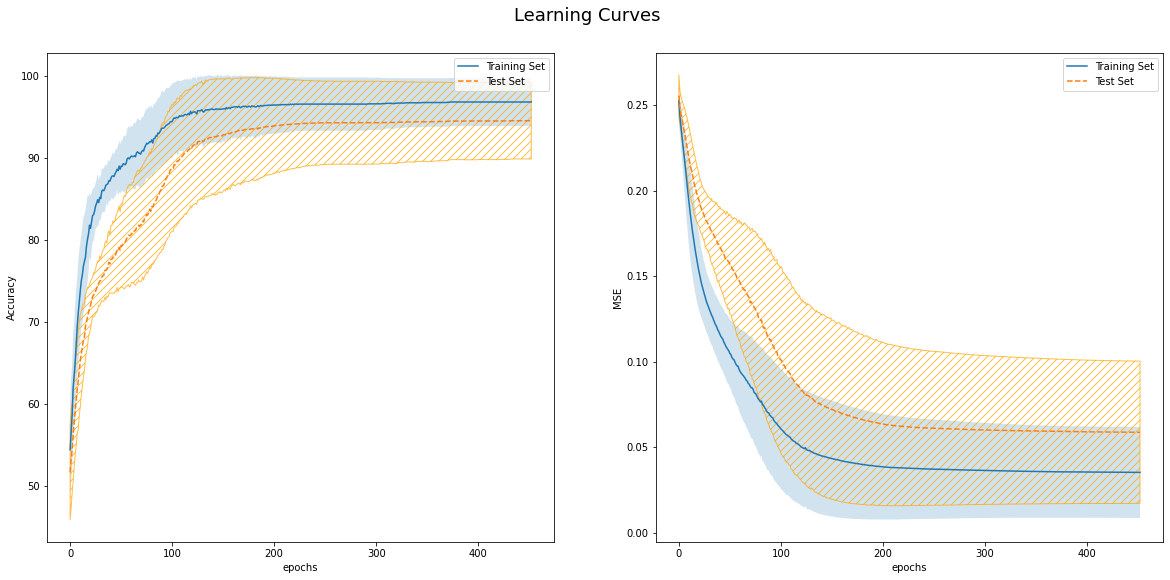

Accuracy on test set:  1.0
Accuracy on training set:  1.0


In [ ]:
tests(training_set, test_set, hyps, 'classification')

## Test Monk2

### Load dataset

In [ ]:
training_set, test_set = load_dataset(2)

### Cross Validation

In [ ]:
hyperparameters = {"architecture": [[17, 3, 1]],
                   'xavier': [False],
                   'activation': ['relu'],
                   "alpha_mom": [0.15, 0.1, 0.05],
                   "lambda_reg": [1e-5, 1e-6, 1e-7],
                   "mb": [25, 50],
                   "eta": [0.5, 0.75, 1 ],
                   "epochs": [600],
                   "eta_decay": [False]
                   }
hyps = cross_validation(training_set, hyperparameters, 5, 4, task='classification')

{'architecture': [17, 3, 1], 'xavier': False, 'activation': 'relu', 'alpha_mom': 0.15, 'lambda_reg': 1e-05, 'mb': 25, 'eta': 0.5, 'epochs': 600, 'eta_decay': False} Tue Jan 17 08:10:22 2023
0-1 Loss on VL: 0.0591 0-1 Loss_std: 0.0911 Training info: 96.73 6.11
{'architecture': [17, 3, 1], 'xavier': False, 'activation': 'relu', 'alpha_mom': 0.15, 'lambda_reg': 1e-05, 'mb': 25, 'eta': 0.75, 'epochs': 600, 'eta_decay': False} Tue Jan 17 08:11:57 2023
0-1 Loss on VL: 0.0106 0-1 Loss_std: 0.0349 Training info: 98.64 4.21
{'architecture': [17, 3, 1], 'xavier': False, 'activation': 'relu', 'alpha_mom': 0.15, 'lambda_reg': 1e-05, 'mb': 25, 'eta': 1, 'epochs': 600, 'eta_decay': False} Tue Jan 17 08:13:11 2023
0-1 Loss on VL: 0.0455 0-1 Loss_std: 0.1025 Training info: 97.1 5.53
{'architecture': [17, 3, 1], 'xavier': False, 'activation': 'relu', 'alpha_mom': 0.15, 'lambda_reg': 1e-05, 'mb': 50, 'eta': 0.5, 'epochs': 600, 'eta_decay': False} Tue Jan 17 08:15:35 2023
0-1 Loss on VL: 0.0727 0-1 Loss_

### Test

In [ ]:
hyps = [{'architecture': [17, 3, 1], 'xavier': False, 'activation': 'relu', 'alpha_mom': 0.15, 'lambda_reg': 1e-06, 'mb': 25, 'eta': 0.5, 'epochs': 600, 'eta_decay': False},
        {'architecture': [17, 3, 1], 'xavier': False, 'activation': 'relu', 'alpha_mom': 0.15, 'lambda_reg': 1e-06, 'mb': 25, 'eta': 1, 'epochs': 600, 'eta_decay': False},
        {'architecture': [17, 3, 1], 'xavier': False, 'activation': 'relu', 'alpha_mom': 0.1, 'lambda_reg': 1e-05, 'mb': 25, 'eta': 1, 'epochs': 600, 'eta_decay': False},
        {'architecture': [17, 3, 1], 'xavier': False, 'activation': 'relu', 'alpha_mom': 0.1, 'lambda_reg': 1e-05, 'mb': 50, 'eta': 1, 'epochs': 600, 'eta_decay': False},
        {'architecture': [17, 3, 1], 'xavier': False, 'activation': 'relu', 'alpha_mom': 0.1, 'lambda_reg': 1e-06, 'mb': 25, 'eta': 0.75, 'epochs': 600, 'eta_decay': False}]

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
<ipython-input-2-14fc9047adb5>:552: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  data[i, j, :] = results[i][j]


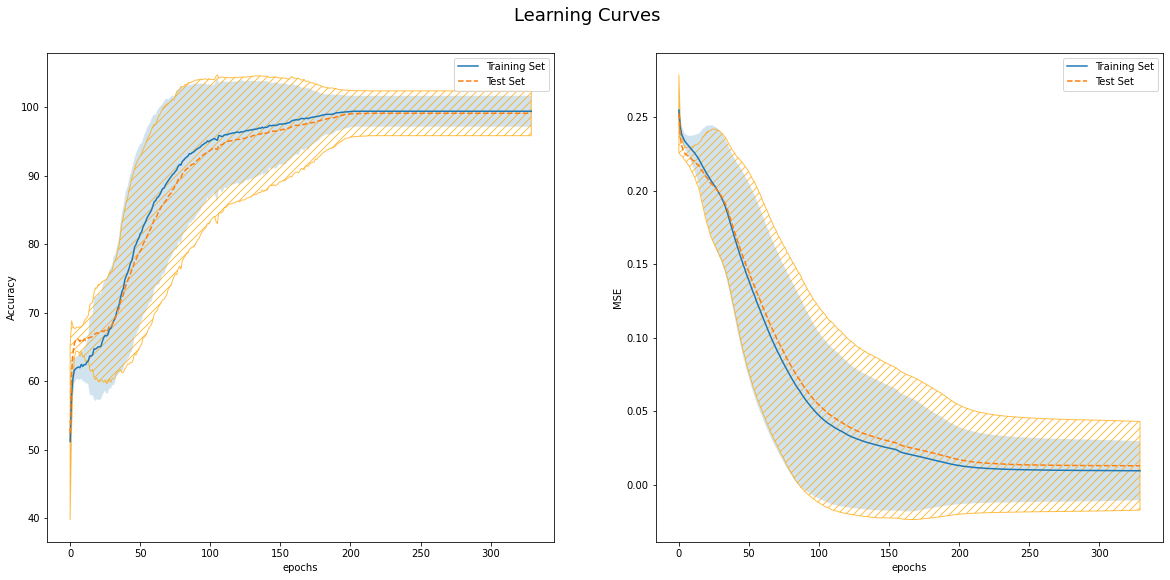

Accuracy on test set:  1.0
Accuracy on training set:  1.0


In [ ]:
tests(training_set, test_set, hyps, 'classification')

## Test Monk3

### Load dataset

In [ ]:
training_set, test_set = load_dataset(3)

### Cross Validation

In [ ]:
hyperparameters = {"architecture": [[17, 3, 1]],
                   'xavier': [False, True],
                   'activation': ['relu', 'sigmoid'],
                   "alpha_mom": [0.15, 0.1, 0.05],
                   "lambda_reg": [1e-5, 1e-6, 1e-7],
                   "mb": [25, 50, 100],
                   "eta": [0.5, 0.75, 1],
                   "epochs": [600],
                   "eta_decay": [False]
                   }
hyps = cross_validation(training_set,
                        hyperparameters,
                        5, 4, task='classification',
                        random_size = 100)

{'architecture': [17, 3, 1], 'xavier': False, 'activation': 'relu', 'alpha_mom': 0.05, 'lambda_reg': 1e-05, 'mb': 100, 'eta': 0.5, 'epochs': 600, 'eta_decay': False} Tue Jan 17 10:58:18 2023
0-1 Loss on VL: 0.075 0-1 Loss_std: 0.0553 Training info: 93.88 1.29
{'architecture': [17, 3, 1], 'xavier': True, 'activation': 'relu', 'alpha_mom': 0.05, 'lambda_reg': 1e-07, 'mb': 100, 'eta': 0.75, 'epochs': 600, 'eta_decay': False} Tue Jan 17 10:58:58 2023
0-1 Loss on VL: 0.0792 0-1 Loss_std: 0.0602 Training info: 94.64 1.2
{'architecture': [17, 3, 1], 'xavier': False, 'activation': 'relu', 'alpha_mom': 0.05, 'lambda_reg': 1e-06, 'mb': 50, 'eta': 0.75, 'epochs': 600, 'eta_decay': False} Tue Jan 17 10:59:35 2023
0-1 Loss on VL: 0.0979 0-1 Loss_std: 0.0563 Training info: 96.07 1.3
{'architecture': [17, 3, 1], 'xavier': True, 'activation': 'sigmoid', 'alpha_mom': 0.1, 'lambda_reg': 1e-06, 'mb': 50, 'eta': 1, 'epochs': 600, 'eta_decay': False} Tue Jan 17 11:00:15 2023
0-1 Loss on VL: 0.075 0-1 Loss_

**Cross validation con iperparametri scelti tra:**
                    
                    {"architecture": [[17, 3, 1]],
                   "xavier" : [True, False],
                   "activation": ["relu", "sigmoid"],
                   "alpha_mom": [ 0.05, 0.1, 0.15],
                   "lambda_reg": [1e-5, 1e-6, 1e-7],
                   "mb": [25, 50, 100],
                   "eta": [0.5, 0.75, 1],
                   "epochs": [600]
                   }
hyps = cross_validation(training_set, hyperparameters, 5, 4)

**Xavier = True**

(0.0053, 0.06, 0.03, 93, {'architecture': [17, 3, 1], 'xavier': True, 'activation': 'sigmoid', 'alpha_mom': 0.05, 'lambda_reg': 1e-05, 'mb': 100, 'eta': 0.75, 'epochs': 600})

(0.0055, 0.06, 0.04, 93, {'architecture': [17, 3, 1], 'xavier': True, 'activation': 'sigmoid', 'alpha_mom': 0.15, 'lambda_reg': 1e-05, 'mb': 100, 'eta': 1, 'epochs': 600})

(0.0056, 0.06, 0.04, 93, {'architecture': [17, 3, 1], 'xavier': True, 'activation': 'sigmoid', 'alpha_mom': 0.05, 'lambda_reg': 1e-05, 'mb': 25, 'eta': 0.5, 'epochs': 600})

(0.0056, 0.06, 0.04, 93, {'architecture': [17, 3, 1], 'xavier': True, 'activation': 'sigmoid', 'alpha_mom': 0.15, 'lambda_reg': 1e-07, 'mb': 100, 'eta': 1, 'epochs': 600})

(0.0059, 0.07, 0.04, 94, {'architecture': [17, 3, 1], 'xavier': True, 'activation': 'sigmoid', 'alpha_mom': 0.05, 'lambda_reg': 1e-06, 'mb': 50, 'eta': 0.75, 'epochs': 600})

**Xavier = False**

(0.0056, 0.07, 0.03, 94, {'architecture': [17, 3, 1], 'xavier': False, 'activation': 'relu', 'alpha_mom': 0.05, 'lambda_reg': 1e-07, 'mb': 100, 'eta': 0.75, 'epochs': 600})

(0.0058, 0.07, 0.03, 94, {'architecture': [17, 3, 1], 'xavier': False, 'activation': 'sigmoid', 'alpha_mom': 0.15, 'lambda_reg': 1e-05, 'mb': 50, 'eta': 0.75, 'epochs': 600})

(0.0059, 0.07, 0.03, 94, {'architecture': [17, 3, 1], 'xavier': False, 'activation': 'relu', 'alpha_mom': 0.1, 'lambda_reg': 1e-07, 'mb': 100, 'eta': 0.75, 'epochs': 600})

(0.0059, 0.07, 0.04, 94, {'architecture': [17, 3, 1], 'xavier': False, 'activation': 'sigmoid', 'alpha_mom': 0.1, 'lambda_reg': 1e-06, 'mb': 50, 'eta': 1, 'epochs': 600})

(0.006, 0.06, 0.04, 94, {'architecture': [17, 3, 1], 'xavier': False, 'activation': 'sigmoid', 'alpha_mom': 0.15, 'lambda_reg': 1e-05, 'mb': 50, 'eta': 0.5, 'epochs': 600})

### Test

In [ ]:
hyps = [{'architecture': [17, 3, 1], 'xavier': True, 'activation': 'sigmoid', 'alpha_mom': 0.1, 'lambda_reg': 1e-07, 'mb': 25, 'eta': 0.5, 'epochs': 600, 'eta_decay': False},
        {'architecture': [17, 3, 1], 'xavier': False, 'activation': 'relu', 'alpha_mom': 0.05, 'lambda_reg': 1e-06, 'mb': 100, 'eta': 0.5, 'epochs': 600, 'eta_decay': False},
        {'architecture': [17, 3, 1], 'xavier': False, 'activation': 'relu', 'alpha_mom': 0.1, 'lambda_reg': 1e-06, 'mb': 100, 'eta': 0.75, 'epochs': 600, 'eta_decay': False},
        {'architecture': [17, 3, 1], 'xavier': True, 'activation': 'sigmoid', 'alpha_mom': 0.15, 'lambda_reg': 1e-06, 'mb': 25, 'eta': 0.75, 'epochs': 600, 'eta_decay': False},
        {'architecture': [17, 3, 1], 'xavier': False, 'activation': 'sigmoid', 'alpha_mom': 0.15, 'lambda_reg': 1e-06, 'mb': 50, 'eta': 0.75, 'epochs': 600, 'eta_decay': False}]

In [ ]:
hyps = [{'architecture': [17, 3, 1], 'xavier': True, 'activation': 'sigmoid', 'alpha_mom': 0.1, 'lambda_reg': 1e-07, 'mb': 25, 'eta': 0.5, 'epochs': 600, 'eta_decay': False}]

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
<ipython-input-5-d489fad1cf43>:152: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  data[i, j, :] = results[i][j]


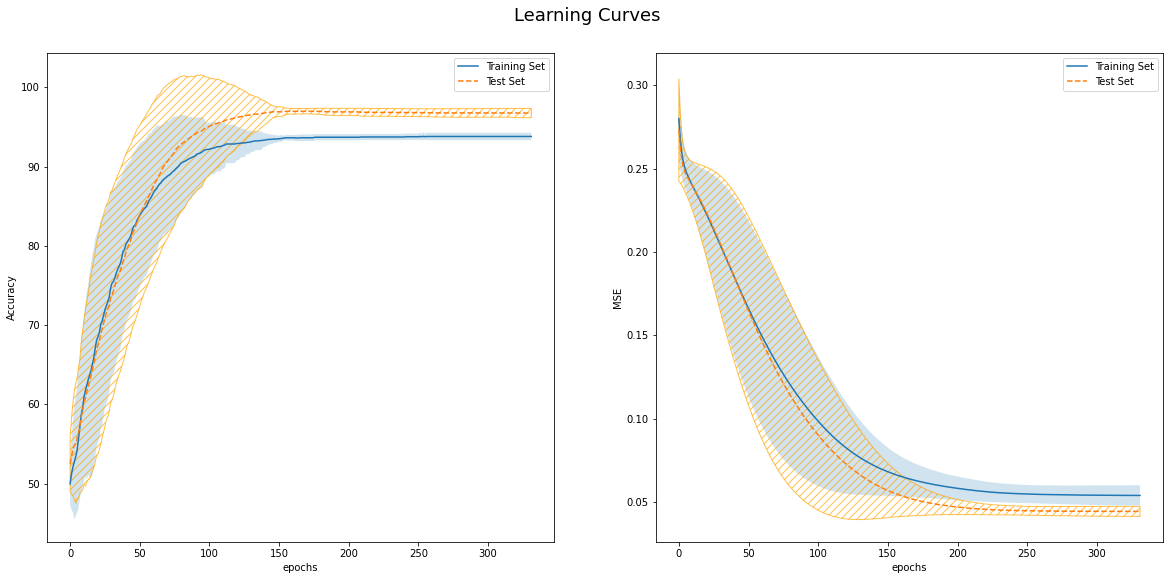

Accuracy on test set:  0.9676
Accuracy on training set:  0.9426


In [ ]:
tests(training_set, test_set, hyps, 'classification')

## Test Monk3 w/o regularization

### Load dataset

In [ ]:
training_set, test_set = load_dataset(3)

### Cross Validation

In [ ]:
hyperparameters = {"architecture": [[17, 3, 1]],
                   'xavier': [True, False],
                   'activation': ['relu', 'sigmoid'],
                   "alpha_mom": [0.15, 0.1, 0.05],
                   "lambda_reg": [0],
                   "mb": [25, 50, 100],
                   "eta": [0.5, 0.75, 1],
                   "epochs": [600],
                   "eta_decay": [False]
                   }
hyps = cross_validation(training_set,
                        hyperparameters,
                        5, 4, task='classification',
                        random_size = 50)

{'architecture': [17, 3, 1], 'xavier': False, 'activation': 'sigmoid', 'alpha_mom': 0.15, 'lambda_reg': 0, 'mb': 50, 'eta': 1, 'epochs': 600, 'eta_decay': False} Tue Jan 17 15:27:30 2023
0-1 Loss on VL: 0.0771 0-1 Loss_std: 0.0401 Training info: 94.34 1.09
{'architecture': [17, 3, 1], 'xavier': False, 'activation': 'relu', 'alpha_mom': 0.15, 'lambda_reg': 0, 'mb': 50, 'eta': 0.75, 'epochs': 600, 'eta_decay': False} Tue Jan 17 15:28:06 2023
0-1 Loss on VL: 0.0937 0-1 Loss_std: 0.0572 Training info: 96.12 1.31
{'architecture': [17, 3, 1], 'xavier': True, 'activation': 'sigmoid', 'alpha_mom': 0.1, 'lambda_reg': 0, 'mb': 100, 'eta': 1, 'epochs': 600, 'eta_decay': False} Tue Jan 17 15:28:51 2023
0-1 Loss on VL: 0.0688 0-1 Loss_std: 0.048 Training info: 93.47 1.18
{'architecture': [17, 3, 1], 'xavier': False, 'activation': 'relu', 'alpha_mom': 0.05, 'lambda_reg': 0, 'mb': 100, 'eta': 1, 'epochs': 600, 'eta_decay': False} Tue Jan 17 15:29:32 2023
0-1 Loss on VL: 0.0792 0-1 Loss_std: 0.032 Tra

### Test

In [ ]:
hyps = [{'architecture': [17, 3, 1], 'xavier': False, 'activation': 'relu', 'alpha_mom': 0.05, 'lambda_reg': 0, 'mb': 100, 'eta': 1, 'epochs': 600, 'eta_decay': False},
        {'architecture': [17, 3, 1], 'xavier': True, 'activation': 'sigmoid', 'alpha_mom': 0.1, 'lambda_reg': 0, 'mb': 25, 'eta': 0.75, 'epochs': 600, 'eta_decay': False},
        {'architecture': [17, 3, 1], 'xavier': False, 'activation': 'sigmoid', 'alpha_mom': 0.05, 'lambda_reg': 0, 'mb': 25, 'eta': 0.5, 'epochs': 600, 'eta_decay': False},
        {'architecture': [17, 3, 1], 'xavier': True, 'activation': 'relu', 'alpha_mom': 0.1, 'lambda_reg': 0, 'mb': 50, 'eta': 1, 'epochs': 600, 'eta_decay': False},
        {'architecture': [17, 3, 1], 'xavier': False, 'activation': 'relu', 'alpha_mom': 0.1, 'lambda_reg': 0, 'mb': 100, 'eta': 0.5, 'epochs': 600, 'eta_decay': False}]

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
<ipython-input-20-d489fad1cf43>:152: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  data[i, j, :] = results[i][j]


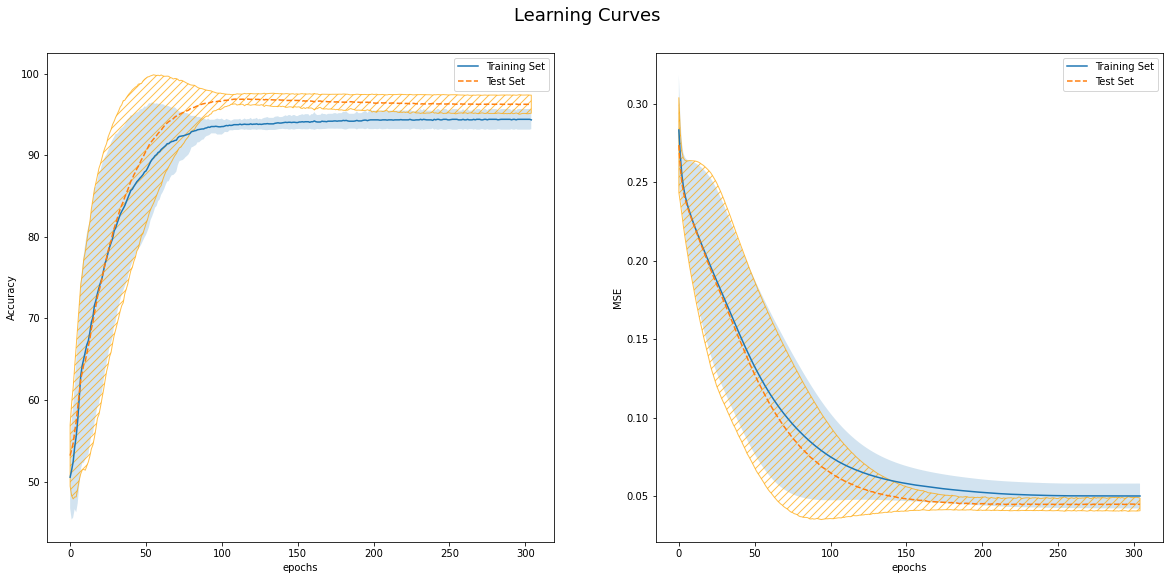

Accuracy on test set:  0.963
Accuracy on training set:  0.9426


In [ ]:
tests(training_set, test_set, hyps, 'classification')

# Regression for ML Cup

## Load data

In [ ]:
training_set, test_set = load_dataset(0)

## Cross Validation

In [ ]:
hyperparameters = {"architecture": [[9, 10, 20, 2],
                                    [9, 15, 15, 2],
                                    [9, 20, 10, 2]],
                   "xavier" : [True, False],
                   "activation": ["sigmoid"],
                   "alpha_mom": [ 0.3, 0.2, 0.1],
                   "lambda_reg": [1e-4, 1e-5, 1e-6],
                   "mb": [100, 130, 170],
                   "eta": [0.3, 0.2, 0.1],
                   "epochs": [180],
                   "eta_decay": [True, False],
                   "tau": [ 25, 35, 50 ,75],
                   "a": [0.8, 1, 1.2]
                   }
best_hyps = cross_validation(training_set,
                             hyperparameters, 
                             5, 3, 'regression', 
                             random_size = 200)

{'architecture': [9, 20, 10, 2], 'xavier': True, 'activation': 'sigmoid', 'alpha_mom': 0.3, 'lambda_reg': 1e-06, 'mb': 100, 'eta': 0.2, 'epochs': 180, 'eta_decay': True, 'tau': 35, 'a': 1} Thu Jan 19 20:30:58 2023
MEE: 1.6289 MEE_std: 0.057 Training info: 1.5895 0.0268
{'architecture': [9, 20, 10, 2], 'xavier': False, 'activation': 'sigmoid', 'alpha_mom': 0.3, 'lambda_reg': 1e-06, 'mb': 100, 'eta': 0.2, 'epochs': 180, 'eta_decay': False, 'tau': 35, 'a': 1.2} Thu Jan 19 20:33:13 2023
MEE: 1.7301 MEE_std: 0.216 Training info: 1.6955 0.2176
{'architecture': [9, 10, 20, 2], 'xavier': True, 'activation': 'sigmoid', 'alpha_mom': 0.3, 'lambda_reg': 0.0001, 'mb': 130, 'eta': 0.2, 'epochs': 180, 'eta_decay': True, 'tau': 25, 'a': 1.2} Thu Jan 19 20:34:38 2023
MEE: 1.6125 MEE_std: 0.0661 Training info: 1.6814 0.0249
{'architecture': [9, 15, 15, 2], 'xavier': False, 'activation': 'sigmoid', 'alpha_mom': 0.1, 'lambda_reg': 0.0001, 'mb': 170, 'eta': 0.2, 'epochs': 180, 'eta_decay': True, 'tau': 75,

## Test

In [ ]:
hyps=[{'architecture': [9, 15, 15, 2], 'xavier': False, 'activation': 'sigmoid', 'alpha_mom': 0.1, 'lambda_reg': 1e-06, 'mb': 110, 'eta': 0.1, 'epochs': 210, 'eta_decay': True, 'tau': 75, 'a': 1.2},
      {'architecture': [9, 15, 15, 2], 'xavier': False, 'activation': 'sigmoid', 'alpha_mom': 0.1, 'lambda_reg': 1e-06, 'mb': 140, 'eta': 0.2, 'epochs': 210, 'eta_decay': True, 'tau': 75, 'a': 1.2},
      {'architecture': [9, 20, 10, 2], 'xavier': False, 'activation': 'sigmoid', 'alpha_mom': 0.1, 'lambda_reg': 1e-06, 'mb': 110, 'eta': 0.2, 'epochs': 210, 'eta_decay': True, 'tau': 50, 'a': 1.2},
      {'architecture': [9, 15, 15, 2], 'xavier': False, 'activation': 'sigmoid', 'alpha_mom': 0.1, 'lambda_reg': 1e-06, 'mb': 140, 'eta': 0.2, 'epochs': 210, 'eta_decay': False, 'tau': 50, 'a': 1.2},
      {'architecture': [9, 20, 10, 2], 'xavier': True, 'activation': 'sigmoid', 'alpha_mom': 0.1, 'lambda_reg': 1e-05, 'mb': 110, 'eta': 0.2, 'epochs': 210, 'eta_decay': False, 'tau': 75, 'a': 1.2}]

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


[array([  79.31181611, -148.59631535]), array([  27.11281589, -127.81843341]), array([ 114.69249049, -133.40708073]), array([  97.4234134 , -141.51893775]), array([  25.62453668, -124.13513059]), array([ 101.28668579, -139.71680752]), array([  39.55449671, -142.40204243]), array([  54.6028429 , -152.64902829]), array([  27.16561668, -127.47596075]), array([  23.401714 , -115.0095576]), array([  93.6431562 , -142.38868171]), array([  68.60801141, -152.04504284]), array([  25.7966087 , -125.02489065]), array([  72.46335033, -150.92230549]), array([  31.85354163, -130.05393745]), array([  24.10693445, -117.92884759]), array([  36.85480109, -139.04946851]), array([  93.18185559, -143.49432488]), array([  98.34010025, -141.32799342]), array([  33.60852498, -136.66147765]), array([ 113.43128371, -134.45320555]), array([  53.95255632, -153.57441552]), array([  87.78668986, -145.48382731]), array([  72.15024141, -150.94420674]), array([  22.46527419, -110.46168088]), array([  89.24565682, -144

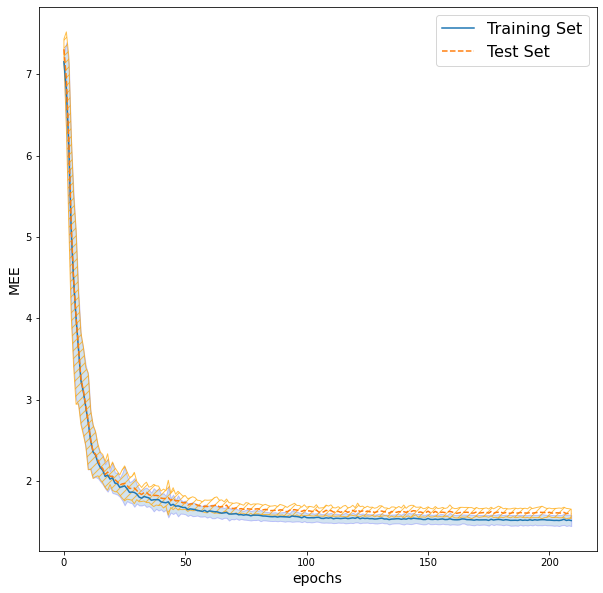

MEE test set =  1.5523
MEE training set =  1.4776


In [ ]:
training_set, test_set = load_dataset(0)
tests(training_set, test_set, hyps, 'regression')

## Final training: full dataset

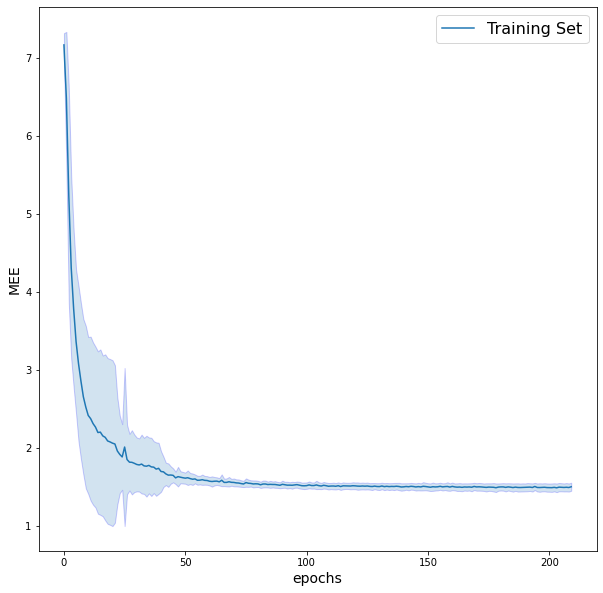

MEE training set =  1.4634


In [ ]:
out_tr, out_ts= blind_tests(training_set, blind_set, hyps)